# Time Series Forecasting with the Long Short-Term Memory Network in Python

Original LInk is here: https://machinelearningmastery.com/time-series-forecasting-long-short-term-memory-network-python/ 


RNN has the promise of learning long sequences of observations. 
t seems a perfect match for time series forecasting, and in fact, it may be.

In this tutorial, you will discover how to develop an LSTM forecast model for a one-step univariate time series forecasting problem.

Goal of this tutorial:

1. How to develop a baseline of performance for a forecast problem
2. How to design a robust test harness for one-step time series forecasting
3. How to prepare data, develop, and evaluate an LSTM recurrent neural network for the time series forecasting

Tutorial overview:

1. Shampoo Sales Dataset
2. Test Setup
3. Persistence MOdel Forecast
4. LSTM Data Preparation
5. LSTM Model Development
6. LSTM Forecast
7. Complete LSTM Example
8. Develop a Robust Result
9. Tutorial Extensions

# 1 Shampoo Sales Dataset

In [1]:
# Digression of strptime investigation
# Syntax: time.strptime(string[, format])
# string − This is the time in string format which would be parsed based on the given format.
# format − This is the directive which would be used to parse the given string.


# Format specifies how the string should be parsed 
# %m stands for month while %M stands for minutes
# %d is day of the month

In [12]:
# Load and plot
from pandas import read_csv
from pandas import datetime
import numpy as np
import pandas as pd
from matplotlib import pyplot
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:


# Load dataset and writing the custom parser
def parser(x):
    return datetime.strptime(x, '%m/%d/%y')

# Man gotta figure out the strptime function to see how it actually works 

# Date_parser always get called to pass a function understand the dates
series=read_csv("/Users/shengyuchen/Dropbox/Engagement - Business/My Hub/AI:ML:DL Playground/Local Python/AI-ML-DL Algorithms/LSTM Neural Networks/shampoo-sales.csv",header=0,parse_dates=[0],index_col=0,squeeze=True,date_parser=parser)
series.head()


ValueError: time data '1-Jan' does not match format '%m/%d/%y'

In [ ]:
series

In [3]:
# Line plot
series.plot()
plt.xticks(rotation=90)
pyplot.show()
# The reason this chart doesn't match up with what's provided because python
# Understands time now and there are missing data for several points across multiple dates
# I guess I will have to try differently to reproduce this

NameError: name 'series' is not defined

In [4]:
filename="/Users/shengyuchen/Dropbox/Engagement - Business/My Hub/AI:ML:DL Playground/Local Python/AI-ML-DL Algorithms/LSTM Neural Networks/shampoo-sales.csv"
def parser(x):
    return datetime.strptime('190'+x, '%Y-%b') # String manpuation
series=read_csv(filename, header=0,parse_dates=[0],index_col=0,squeeze=True)

# If the parsed data only contains one column then return a Series


In [5]:
labels=pd.date_range(start="1901-1-1",periods=len(series),freq="MS")
# Man this frequency is tricky. If just say M, it means month end.....
labels
series.index=labels

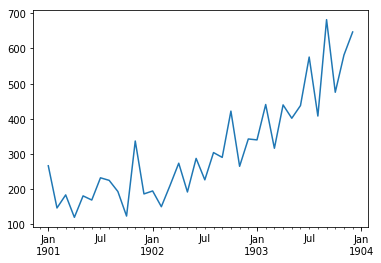

In [6]:
series.plot()
pyplot.show()
# Now this fully replicates what this guy has

# 2 Experimental Test Setup

1. Spliting the dataset into two parts: one training and one test
2. The first two years of data will be taken for the training dataset and the remaining one year of data will be for test set

In [10]:
X=series.values
train,test=X[0:-12],X[-12:]

#### Import things about how the model is to be trained
A rolling forecast scenario will be used. It is also called the walk forward model validation. Each time step of the test dataset will be walked one aat a time. A model will be used to make a forecast for the time step. Then the actual expected value from the test set will be taken and made available to the next time step

This mimics a real-world scenario where new Shampoo Sales observations would be available each month and used in the forecasting of the following month.

Finally, all forecasts on the test dataset will be collected and an error score calculated to summarize the skill of the model. The RMSE is used as it punishes large errors and results in a score that is in the same units as the forecast data, namely monthly shampoo sales.

#### Test code
from sklearn.metrics import mean_squared_error


import numpy as np


rmse=np.sqrt(mean_squared_error(test,predictions))


print("RMSE: %.3f" %rmse) # This really mimics the way in SAS how RMSE is handled

# 3 Persistence Model Forecast 
A good baseline forecast for a time series with a linear increasing trend is a persistence forecast. 

The persistence forecast is where the observation from the prior time step is used to predict the observation at the current time step

This can be implemented by taking the last observation from the training data and histroy accumulated by walk forward validation and use that to predict the current time step

We can accumulate all predictions in an array so that they can be directly compared to the test dataset

In [11]:
# Contiue from the above
# Walk forward validation
history = [ x for x in train]
predictions=list()
for i in range(len(test)):
    #make prediction
    predictions.append(history[-1])
    # Observation
    history.append(test[i])
# report performance
rmse=np.sqrt(mean_squared_error(test,predictions))
print("RMSE: %.3f" % rmse)
#plotting this out
plt.plot(test)
plt.plot(predictions)
plt.show()
# This is simply the result of shifting the curve forward by 1 period

NameError: name 'np' is not defined

# 4 LSTM Data Preparation
Before actually fitting the LSTM model to the dataset, we need to transform the data.

Here there are 3 things that need to be taken care of:

1. Transform the time series into a supervised learning problem
2. Transform the time series data so that it is stationary
3. Transform the observations to have a specific scale

### Transforming time series into a supervised learning problem 

The LSTM model in Keras assumes that the data is divided into input(X) and output(y)

For the time series problem, this can be achieved by using the observation from the alst time step as input and the observation at the curretn time step as the output. 

We can achive this through using the shift() function in pandas. we would shift the time series by 1 place then the current time series as it stands is the output. 

We can then concatenate the two series together to create DF for supervised learning. The pushed down series will have a new position at the top with no value. A Nan value will be used here. We can use 0 to replace Nan. The LSTM model then has to learn as the start of the series as a month with zero sales on this dataset has not been observed. 

In [13]:
pd.DataFrame(X).shift(1)[:10]
# So shift basically takes the input array and shift them down by specified
# number of rows in the table

,0
0,NaN
1,266.0
2,145.9
3,183.1
4,119.3
5,180.3
6,168.5
7,231.8
8,224.5
9,192.8


In [14]:
# Helper function that takes numpy array of the raw time series and a lag or number of shifted series to create 
# and use as inputs
def timeseries_to_supervised(data,lag=1):
    df=pd.DataFrame(data)
    columns=[df.shift(i) for i in range(1,lag+1)] # depends on how many lags are required
    columns.append(df) # Appending list to each other 
    df=pd.concat(columns,axis=1)
    df.fillna(0,inplace=True) #takes care of the Nan value
    return df

In [15]:
# Testing the function with Shampoo dataset and convert this into a supervised learning problem
from pandas import read_csv
from pandas import datetime
from pandas import concat

supervised=timeseries_to_supervised(X,1)
supervised.head()

,0,0
0,0.0,266.0
1,266.0,145.9
2,145.9,183.1
3,183.1,119.3
4,119.3,180.3


### Transform Time Series to Stationary

The time series sales dataset isn't stationary. There's a structure in the data that's dependent on time. In fact there's an increasing trend in the data. 

Stationary data is easier to model and will very likely result in more skillful forecasts. 

The trend can be removed from observations, then added back to forecasts later to return the prediction to the original scale and calculate a comprable error score. 

A standard way to remove a trend is by differencing the data. That is the observation from previous time step (t-1) is substracted from the current observation (t). This removes the trend and we are left with a different series, or the changes to the observations from one time step to the next. 

We can achieve this automatically using the diff() function in pandas. Alternatively, we can get more finer grained control and create our own function to compute the differences. 

Custom difference function:

In [16]:
def difference(dataset,interval=1):
    diff=list()
    for i in range(interval, len(dataset)):
        value=dataset[i]-dataset[i-interval] # calcualting row vs row(-1) differnce
        diff.append(value)
    return pd.Series(diff)

# Not sure what this differencing does as of right now

This process also needs to be inverted in order to take forecasts made on the differenced series back into the original scale. 

In [17]:
# invert differenced value
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]

### Testing out these two functions

In [18]:
# Transform the dataset to make it stationary
differenced=difference(series,1)
print(differenced.head())

0   -120.1
1     37.2
2    -63.8
3     61.0
4    -11.8
dtype: float64


In [19]:
# Invert transform
inverted=list()
for i in range(len(differenced)):
    value=inverse_difference(series, differenced[i],len(series)-i)
    inverted.append(value)
inverted=pd.Series(inverted)  
print(inverted.head())

0    145.9
1    183.1
2    119.3
3    180.3
4    168.5
dtype: float64


# Transform Time series to Scale

LSTMs expect data to be within the scale of the activation function used by the network. 

The default activation function for LSTMs is the hyperbolic tangent which outputs value between -1 and 1. This is the prefererred range for the time series data. 

To make the experiment fair, the scaling coefficients values must be calculated on the training dataset and applied to scale the terst dataset and any forecasts . This is to avoid contaminating the experiment with knowledge from the test dataset, which might give the model a small edge.

We can transform the dataset to the range [-1,1] using the minmixscaler class. This is a scikit learn transform classes. It requires provided in a matrix format with rows and columns. We need to reshape the numpy arrays before transforming. 

In [21]:
X=series.values
X

array([ 266. ,  145.9,  183.1,  119.3,  180.3,  168.5,  231.8,  224.5,
        192.8,  122.9,  336.5,  185.9,  194.3,  149.5,  210.1,  273.3,
        191.4,  287. ,  226. ,  303.6,  289.9,  421.6,  264.5,  342.3,
        339.7,  440.4,  315.9,  439.3,  401.3,  437.4,  575.5,  407.6,
        682. ,  475.3,  581.3,  646.9])

In [24]:
X=X.reshape(len(X),1) #Reshaping the input arrays into 1 by len(x) matrix
X

array([[ 266. ],
       [ 145.9],
       [ 183.1],
       [ 119.3],
       [ 180.3],
       [ 168.5],
       [ 231.8],
       [ 224.5],
       [ 192.8],
       [ 122.9],
       [ 336.5],
       [ 185.9],
       [ 194.3],
       [ 149.5],
       [ 210.1],
       [ 273.3],
       [ 191.4],
       [ 287. ],
       [ 226. ],
       [ 303.6],
       [ 289.9],
       [ 421.6],
       [ 264.5],
       [ 342.3],
       [ 339.7],
       [ 440.4],
       [ 315.9],
       [ 439.3],
       [ 401.3],
       [ 437.4],
       [ 575.5],
       [ 407.6],
       [ 682. ],
       [ 475.3],
       [ 581.3],
       [ 646.9]])

In [31]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(-1,1)) # Again storing it as a variable
scaler

# A note about the MinMaxScaler: it transforms features by scaling each feature 
# to a given range. The estimator scales and tanslates each feature individually such that it is 
# in the given range of the traninig set

MinMaxScaler(copy=True, feature_range=(-1, 1))

In [32]:
scaler=scaler.fit(X) # What does this fit do?
scaler

MinMaxScaler(copy=True, feature_range=(-1, 1))

In [35]:
scaled_X=scaler.transform(X) #Damn what's the difference between transform and scaler?
scaled_X[:10]

array([[-0.47858539],
       [-0.90545584],
       [-0.77323618],
       [-1.        ],
       [-0.7831882 ],
       [-0.82512884],
       [-0.60014217],
       [-0.6260885 ],
       [-0.73875955],
       [-0.98720455]])

In [38]:
# Invert transform
inverted_X=scaler.inverse_transform(scaled_X)
inverted_X[:10] # Fitting this first and then transforom this back 

array([[ 266. ],
       [ 145.9],
       [ 183.1],
       [ 119.3],
       [ 180.3],
       [ 168.5],
       [ 231.8],
       [ 224.5],
       [ 192.8],
       [ 122.9]])

# LSTM MOdel Development

The data for the LSTM network is done and we can start developing the model.

A benefit of this type of network is that it can learn and remember over long sequences and does not reply on pre-specified window lagged observation as input. 

In Keras, this is referred to as stateful, and involves setting the stateful argument True when defining an LSTM layer. 

By default, an LSTM layer in keras maintains state between data within one batch. A batch of data is a fixed sized number of rows from the training dataset that defines how many patterns to process before updating the weights of the network. State in the LSTM layer between batches is cleared by default, therefore we must make the LSTM stateful. This gives us fine grained control over when state of the LSTM layer is cleared, by calling the reset_states() function.

The LSTM layer expects input to be in a matrix with the dimensions [samples, time steps, features] 
1. Samples: These are independent observations from the domain, typically rows of data
2. Time Steps: these are separate time steps of a given variable for a given observation
3. These are separate measures observed at the time of observation 

Given that the training set is defined as X inputs and y outputs, the dataset must be reshaped into (Samples, timesteps, features 


In [49]:
X,y=train[;0:-1], train[;-1]
X

array([ 266. ,  145.9,  183.1,  119.3,  180.3,  168.5,  231.8,  224.5,
        192.8,  122.9,  336.5,  185.9,  194.3,  149.5,  210.1,  273.3,
        191.4,  287. ,  226. ,  303.6,  289.9,  421.6,  264.5])

In [50]:
y

342.30000000000001

In [ ]:
X=X.reshape(X,shape[0],1,X.shape[1])